In [ ]:
!pip install numpy==1.26.0
!pip install thinc==8.2.5
!pip install tensorflow==2.17.1
!pip install spacy tf-keras
!pip install --upgrade cupy-cuda12x gensim langchain matplotlib numba pytensor pyxdf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.5/58.5 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 34.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain 0.3.19 requires numpy<2,>=1.26.4; python_version < "3.12", but you have numpy 1.26.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 57.9 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.18.0
    Uninstalling tensorboard-2.18.0:
      Successfully uninstalled tensorboard-2.18.0
  Attempting uninstall: tensorflow
    Found existing installatio

In [ ]:
!pip freeze > requirements.txt

In [ ]:
import os
import logging
import glob
import pyxdf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from abc import ABC, abstractmethod
from typing import Optional, Tuple, List, Type, Dict

logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

In [ ]:
class DataLoader(ABC):
    def __init__(self, base_path: str, subject_name: str, session_number: str, run_number: str) -> None:
        self.base_path: str = base_path
        self.subject_name: str = subject_name
        self.session_number: str = session_number
        self.run_number: str = run_number
        self.extension: Optional[str] = None  # To be defined in subclass
        self.file_path: Optional[str] = None  # Set by `_find_file`

    def _find_file(self) -> str:
        """
        Locate the target file in the directory structure based on subject and condition.
        Returns the full file path.
        """
        subject_dir = os.path.join(self.base_path, self.subject_name)
        if not os.path.exists(subject_dir):
            raise FileNotFoundError(f"Subject folder '{subject_dir}' not found.")

        file_name = f"{self.session_number}{self.extension}"
        file_path = os.path.join(subject_dir, file_name)

        if not os.path.exists(file_path):
            raise FileNotFoundError(f"File '{file_name}' not found in '{subject_dir}'.")

        return file_path

    @abstractmethod
    def load(self) -> object:
        """Implementation in subclasses."""
        pass

In [ ]:
class DataLoaderFactory:
    loaders = {}

    @classmethod
    def register_loader(cls, file_format: str):
        def decorator(loader_cls):
            cls.loaders[file_format] = loader_cls
            return loader_cls
        return decorator

    @classmethod
    def create_data_loader(
        cls,
        base_path: str,
        subject_name: str,
        session_number: str,
        run_number: str,
        file_format: str
      ) -> DataLoader:
        if file_format not in cls.loaders:
            raise ValueError(f"Unsupported file format: {file_format}")
        return cls.loaders[file_format](base_path, subject_name, session_number, run_number)

In [ ]:
@DataLoaderFactory.register_loader("xdf")
class XDFLoader(DataLoader):
    def __init__(
        self,
        base_path: str,
        subject_name: str,
        session_number: str,
        run_number: str
    ) -> None:
        """
        Initialize the XDFLoader with subject, session number, and run number.
        """
        super().__init__(base_path, subject_name, session_number, run_number)
        self.extension: str = ".xdf"
        self.file_path: Optional[str] = self._find_file()

    def _find_file(self) -> str:
        """
        Locate the XDF file dynamically, allowing for variations in filename.
        """
        subject_folder = f"sub-{self.subject_name}"
        session_folder = f"ses-{self.session_number}"
        folder_path = os.path.join(self.base_path, subject_folder, session_folder, "eeg")

        search_pattern = os.path.join(
            folder_path,
            f"sub-{self.subject_name}_ses-{self.session_number}_*run-{self.run_number}*.xdf"
        )
        matching_files = glob.glob(search_pattern)

        if not matching_files:
            raise FileNotFoundError(f"No matching XDF files found for: {search_pattern}")

        return matching_files[0]  # Use the first match

    def load(self) -> Tuple[List[dict], dict]:
        """
        Load an XDF file and return the data and header.

        Returns:
        - List of dictionaries containing EEG stream data.
        - Dictionary containing header information.
        """
        try:
            data, header = pyxdf.load_xdf(self.file_path)
            logger.info(f"Successfully loaded XDF file: {self.file_path}")
            return data, header
        except Exception as e:
            logger.error(f"Error loading XDF file {self.file_path}: {e}")
            return [], {}


In [ ]:
def compute_average_sample_frequency(data: List[Dict]) -> Dict[str, float]:
    """
    Computes the average sample frequency for each stream.

    Parameters:
    - data: List of dictionaries containing EEG stream data.

    Returns:
    - Dictionary mapping stream names to their average sample frequency.
    """
    sample_frequencies = {}
    for stream in data:
        stream_name = stream["info"]["name"][0]
        timestamps = np.array(stream["time_stamps"])

        if len(timestamps) > 1:
            avg_sample_freq = 1 / np.mean(np.diff(timestamps))
        else:
            avg_sample_freq = 0.0

        sample_frequencies[stream_name] = avg_sample_freq

    return sample_frequencies

def extract_pressure_data(data: List[Dict], rows: int, columns: int) -> Dict[str, Dict[str, np.ndarray]]:
    """
    Extracts and reshapes pressure sensor data streams from XDF data.

    Parameters:
    - data: List of dictionaries containing XDF stream data.
    - rows: Number of rows in the pressure matrix.
    - columns: Number of columns in the pressure matrix.

    Returns:
    - Dictionary containing reshaped time-series data and timestamps for pressure sensors.
    """
    pressure_sensors = {}

    for stream in data:
        stream_name = stream["info"]["name"][0]
        if "PressureSensor" in stream_name:
            time_series = np.array(stream["time_series"])
            reshaped_series = [np.reshape(sample, (rows, columns)) for sample in time_series]
            pressure_sensors[stream_name] = {
                "time_series": reshaped_series,
                "time_stamps": np.array(stream["time_stamps"])
            }
            print(f"Assigned {stream_name} to pressure sensor data.")

    if not pressure_sensors:
        print("No pressure sensor streams found.")

    return pressure_sensors


In [ ]:
def get_transposed_matrices(pressure_matrices: Dict[str, np.ndarray]) -> Dict[str, List[np.ndarray]]:
    """
    Transposes and reshapes the pressure data matrices.

    Parameters:
    - pressure_matrices: Dictionary containing transformed pressure matrices.

    Returns:
    - Dictionary containing transposed pressure matrices.
    """
    return {sensor: [np.transpose(matrix) for matrix in matrices] for sensor, matrices in pressure_matrices.items()}

def get_matrix_dimension(pressure_matrices: Dict[str, List[np.ndarray]], top_fraction: float = 0.5) -> Dict[str, List[np.ndarray]]:
    """
    Extracts a fraction of the matrices' columns based on the specified dimension.

    Parameters:
    - pressure_matrices: Dictionary containing pressure matrices.
    - top_fraction: Fraction of the columns to extract (default is 0.5 for the top half).

    Returns:
    - Dictionary containing matrices with the specified fraction of columns.
    """
    return {
        sensor: [matrix[:, :int(matrix.shape[1] * top_fraction)] for matrix in matrices]
        for sensor, matrices in pressure_matrices.items()
    }

In [ ]:
import cv2

def single_heat_map_plot(pressure_map: np.ndarray, location: str) -> None:
    """
    Generates a single heat map plot for pressure data.
    """
    fig, ax = plt.subplots(figsize=(3, 3))
    sns.heatmap(pressure_map, annot=False, cmap='viridis', ax=ax)
    plt.title(location)
    plt.tight_layout()
    plt.show()

def matrix_to_video(pm_list, out_file, fps=30, size=(600, 600)):
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    writer = cv2.VideoWriter(out_file, fourcc, fps, size)

    for pressure_map in pm_list:
        min_val = np.min(pressure_map)
        max_val = np.max(pressure_map)
        norm = (pressure_map - min_val) / (max_val - min_val) if max_val != min_val else np.zeros_like(pressure_map)
        img = (norm * 255).astype(np.uint8)
        img_color = cv2.applyColorMap(img, cv2.COLORMAP_VIRIDIS)
        frame = cv2.resize(img_color, size, interpolation=cv2.INTER_NEAREST)
        writer.write(frame)

    writer.release()
    print(f"Video saved to {out_file}")

INFO:__main__:Successfully loaded XDF file: /content/drive/MyDrive/Tekscan/AFP_pressure_data/sub-P008/ses-S002/eeg/sub-P008_ses-S002_task-Default_run-002_eeg.xdf


Assigned PressureSensor_2 to pressure sensor data.
Assigned PressureSensor_1 to pressure sensor data.
Extracted Streams: ['PressureSensor_2', 'PressureSensor_1']


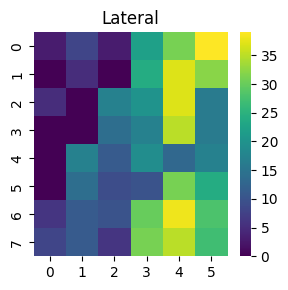

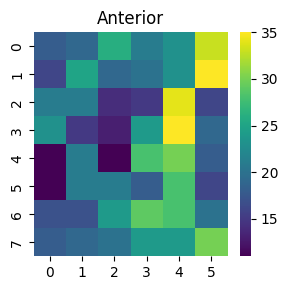

Video saved to /content/output.mp4


In [ ]:
def main():
    factory = DataLoaderFactory()

    xdf_loader = factory.create_data_loader(
        base_path="<YOUR_PATH>",
        subject_name="P008",
        session_number="S002",
        run_number="002",
        file_format="xdf"
    )

    data, header = xdf_loader.load()  #Some type hinting error
    # print(data[0])

    pressure_streams = extract_pressure_data(data, rows=12, columns=8)
    print(f"Extracted Streams: {list(pressure_streams.keys())}")

    transposed_matrices = get_transposed_matrices(
        {
            sensor: data["time_series"]
            for sensor, data in pressure_streams.items()
        }
    )
    extracted_matrices = get_matrix_dimension(transposed_matrices)
    pressure_maps1, pressure_maps2 = extracted_matrices.values()

    return pressure_maps1, pressure_maps2

if __name__ == "__main__":
    pressure_maps1, pressure_maps2 = main()

    single_heat_map_plot(pressure_maps1[999], "Lateral")
    single_heat_map_plot(pressure_maps2[999], "Anterior")

    out_path = os.path.join(os.getcwd(), "output.mp4")
    matrix_to_video(pressure_maps2, out_file=out_path)